# Wczytanie gotowego zestawu przetworzonych danych


In [9]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data/preprocessed_data.csv')

# Wczytanie predykcji PSE

In [10]:
df_pse = pd.read_csv('data/predictions_pse.csv')

# Wczytanie skalarów i normalizacja danych wejściowych modeli

In [11]:
import joblib
import numpy as np
import os

path = 'scalers'
scalers = {}

for filename in os.listdir(path):
    if filename.startswith('scaler_') and filename.endswith('.pkl'):
        scaler_path = os.path.join(path, filename)
        scaler = joblib.load(scaler_path)
        column_name = filename[len('scaler_'):-len('.pkl')]
        scalers[column_name] = scaler


def scale_data(data, scalers):
    data_scaled = data.copy()
    for column in data.columns:
        scaler = scalers[column]
        data_scaled[column] = scaler.transform(data[column].values.reshape(-1, 1))
    return data_scaled


test_24h_data = df.iloc[-48:-24]
test_24h_scaled = scale_data(test_24h_data, scalers)
test_24h_scaled = np.array([test_24h_scaled])

# Definicja funkcji błędów

In [12]:
import tensorflow as tf

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

# Wczytanie wytrenowanych modeli

In [13]:
# Modele FFANN
model_1_ffann = tf.keras.models.load_model('models/model_1_ffann.h5', custom_objects={'rmse': rmse})
model_2_ffann = tf.keras.models.load_model('models/model_2_ffann.h5', custom_objects={'rmse': rmse}) # Najlepszy model FFANN
model_3_ffann = tf.keras.models.load_model('models/model_3_ffann.h5', custom_objects={'rmse': rmse})

# Modele FFANN optymalizowane algorytmem PSO
model_4_pso = tf.keras.models.load_model('models/model_4_pso.h5', custom_objects={'rmse': rmse}) # Najlepszy model FFANN optymalizowany algorytmem PSO
model_5_pso = tf.keras.models.load_model('models/model_5_pso.h5', custom_objects={'rmse': rmse})
model_6_pso = tf.keras.models.load_model('models/model_6_pso.h5', custom_objects={'rmse': rmse})

# Modele LSTM
model_7_lstm = tf.keras.models.load_model('models/model_7_lstm.h5', custom_objects={'rmse': rmse}) # Najlepszy model LSTM i optymalany ze wszystkich opracowanych
model_8_lstm = tf.keras.models.load_model('models/model_8_lstm.h5', custom_objects={'rmse': rmse})
model_9_lstm = tf.keras.models.load_model('models/model_9_lstm.h5', custom_objects={'rmse': rmse})

# Predykcje najlepszych modeli oraz ich wizualizacja

1/1 [==============================] - 4s 4s/step


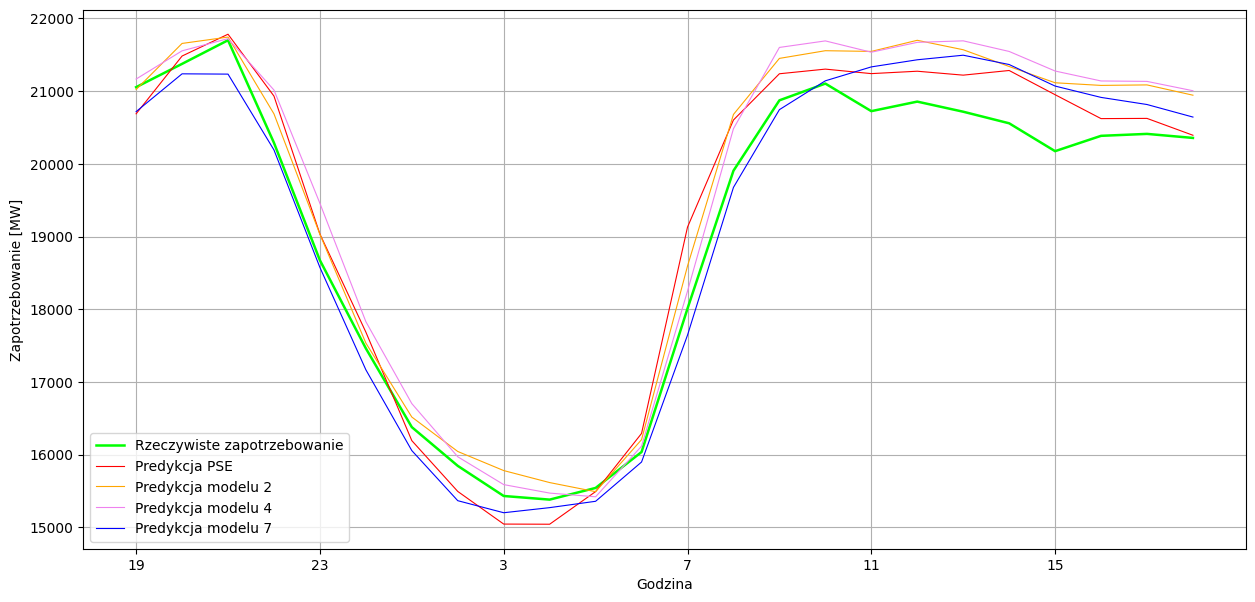

In [14]:
predictions_24h_mlp = model_2_ffann.predict(test_24h_scaled)
predictions_24h_pso = model_4_pso.predict(test_24h_scaled)
predictions_24h_lstm = model_7_lstm.predict(test_24h_scaled)

predictions_24h_mlp = scalers['electricity_load'].inverse_transform(predictions_24h_mlp)
predictions_24h_mlp = predictions_24h_mlp.reshape(-1).tolist()

predictions_24h_pso = scalers['electricity_load'].inverse_transform(predictions_24h_pso)
predictions_24h_pso = predictions_24h_pso.reshape(-1).tolist()

predictions_24h_lstm = scalers['electricity_load'].inverse_transform(predictions_24h_lstm)
predictions_24h_lstm = predictions_24h_lstm.reshape(-1).tolist()

actual_values = df_pse['electricity_load'].tail(24).values
pse_predictions = df_pse['forecasted_load'].tail(24).values
hour_labels = df_pse['hour'].tail(24).tolist()

plt.figure(figsize=(15, 7))
plt.plot(actual_values, label='Rzeczywiste zapotrzebowanie', color='lime', linewidth=1.8)
plt.plot(pse_predictions, label='Predykcja PSE', color='red', linewidth=0.8)
plt.plot(predictions_24h_mlp, label='Predykcja modelu 2', color='orange', linewidth=0.8)
plt.plot(predictions_24h_pso, label='Predykcja modelu 4', color='violet', linewidth=0.8)
plt.plot(predictions_24h_lstm, label='Predykcja modelu 7', color='blue', linewidth=0.8)
plt.xlabel('Godzina')
plt.ylabel('Zapotrzebowanie [MW]')
plt.legend()
ticks = range(0, 24, 4)
selected_labels = [hour_labels[i] for i in ticks]
plt.xticks(ticks=ticks, labels=selected_labels)
plt.grid(True)
plt.show()